# Assignment

In [17]:
# Import 

import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from degree_freedom_queen import *
from degree_freedom_king1 import *
from degree_freedom_king2 import *
from generate_game import *
from Chess_env import *
from tqdm.notebook import tqdm
import pandas as pd

size_board = 4

## The Environment

You can find the environment in the file Chess_env, which contains the class Chess_env. To define an object, you need to provide the board size considered as input. In our example, size_board=4. 
Chess_env is composed by the following methods:

1. Initialise_game. The method initialises an episode by placing the three pieces considered (Agent's king and queen, enemy's king) in the chess board. The outputs of the method are described below in order.

     S $\;$ A matrix representing the board locations filled with 4 numbers: 0, no piece in that position; 1, location of the 
     agent's king; 2 location of the queen; 3 location of the enemy king.
     
     X $\;$ The features, that is the input to the neural network. See the assignment for more information regarding the            definition of the features adopted. To personalise this, go into the Features method of the class Chess_env() and change        accordingly.
     
     allowed_a $\;$ The allowed actions that the agent can make. The agent is moving a king, with a total number of 8                possible actions, and a queen, with a total number of $(board_{size}-1)\times 8$ actions. The total number of possible actions correspond      to the sum of the two, but not all actions are allowed in a given position (movements to locations outside the borders or      against chess rules). Thus, the variable allowed_a is a vector that is one (zero) for an action that the agent can (can't)      make. Be careful, apply the policy considered on the actions that are allowed only.
     

2. OneStep. The method performs a one step update of the system. Given as input the action selected by the agent, it updates the chess board by performing that action and the response of the enemy king (which is a random allowed action in the settings considered). The first three outputs are the same as for the Initialise_game method, but the variables are computed for the position reached after the update of the system. The fourth and fifth outputs are:

     R $\;$ The reward. To change this, look at the OneStep method of the class where the rewards are set.
     
     Done $\;$ A variable that is 1 if the episode has ended (checkmate or draw).
     
     
3. Features. Given the chessboard position, the method computes the features.

This information and a quick analysis of the class should be all you need to get going. The other functions that the class exploits are uncommented and constitute an example on how not to write a python code. You can take a look at them if you want, but it is not necessary.






In [57]:
## INITIALISE THE ENVIRONMENT
env=Chess_Env(size_board)

In [123]:
# INITIALISE THE PARAMETERS OF YOUR NEURAL NETWORK AND...
# PLEASE CONSIDER TO USE A MASK OF ONE FOR THE ACTION MADE AND ZERO OTHERWISE IF YOU ARE NOT USING VANILLA GRADIENT DESCENT...
# WE SUGGEST A NETWORK WITH ONE HIDDEN LAYER WITH SIZE 200. 
np.random.seed(44) # 41, 42, 43, 44, 45
S,X,allowed_a=env.Initialise_game()
N_a = np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS

N_in = np.shape(X)[0]    ## INPUT SIZE
N_h = 200                ## NUMBER OF HIDDEN NODES


## INITALISE YOUR NEURAL NETWORK..
W1 = np.random.uniform(0,1,(N_h, N_in))
W2 = np.random.uniform(0,1,(N_a, N_h))
W1 = np.divide(W1,np.matlib.repmat(np.sum(W1,1)[:,None],1,N_in))
W2 = np.divide(W2,np.matlib.repmat(np.sum(W2,1)[:,None],1,N_h))

bias_W1 = np.zeros((N_h,))
bias_W2 = np.zeros((N_a,))

is_RMSprop = False
if is_RMSprop:
  squared_gradients = np.zeros(4)

# HYPERPARAMETERS SUGGESTED (FOR A GRID SIZE OF 4)

epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.0035        # THE LEARNING RATE

N_episodes = 10000 # THE NUMBER OF GAMES TO BE PLAYED
algorithm = "Q"

# SAVING VARIABLES
R_save = np.zeros(N_episodes)
N_moves_save = np.zeros(N_episodes)
gradients_save_average = []
# RMSgradients_save_average = []

def predict(x0, W1, W2, bias_W1, bias_W2):
    h1 = np.dot(W1, x0) + bias_W1
    x1 = 1 / (1 + np.exp(-h1))
    h2 = np.dot(W2, x1) + bias_W2
    x2 = 1 / (1 + np.exp(-h2))
    return x1, x2

def backprop(R, q, q_err, a, x0, x1, W1, W2, bias_W1, bias_W2):
    delta2 = q*(1-q) * q_err
    dW2 = np.outer(delta2, x1)
    delta1 = x1*(1-x1) * np.dot(W2.T, delta2)
    dW1 = np.outer(delta1, x0)
    
    W1 += eta * dW1
    W2 += eta * dW2
    bias_W1 += eta * delta1
    bias_W2 += eta * delta2
    
    mean1 = np.mean(eta * dW1)
    mean2 = np.mean(eta * dW2)
    gradients_save_average.append((mean1 + mean2)/2)
    
    return W1, W2, bias_W1, bias_W2
  
def RMSprop(R, q, q_err, a, x0, x1, W1, W2, bias_W1, bias_W2, squared_gradients):
    delta2 = q*(1-q) * q_err
    dW2 = np.outer(delta2, x1)
    delta1 = x1*(1-x1) * np.dot(W2.T, delta2)
    dW1 = np.outer(delta1, x0)
    
    rms_beta = 0.9
    dW1_squared = rms_beta * squared_gradients[0] + (1-rms_beta) * np.square(dW1) # weighted average of previous squared gradient
    dW2_squared = rms_beta * squared_gradients[1] + (1-rms_beta) * np.square(dW2) # and current squared gradient
    alpha1 = eta / (1e-6 + np.sqrt(dW1_squared))
    alpha2 = eta / (1e-6 + np.sqrt(dW2_squared))
    
    db1_squared = rms_beta * squared_gradients[2] + (1-rms_beta) * np.square(delta1)
    db2_squared = rms_beta * squared_gradients[3] + (1-rms_beta) * np.square(delta2)
    alpha1b = eta / (1e-6 + np.sqrt(db1_squared))
    alpha2b = eta / (1e-6 + np.sqrt(db2_squared))
    
    W1 += alpha1 * dW1
    W2 += alpha2 * dW2
    bias_W1 += alpha1b * delta1
    bias_W2 += alpha2b * delta2
    
    mean1 = np.mean(alpha1 * dW1)
    mean2 = np.mean(alpha2 * dW2)
    RMSgradients_save_average.append((mean1 + mean2)/2)
    
    new_squared_gradients = np.array([dW1_squared, dW2_squared, db1_squared, db2_squared], dtype=object)
    return W1, W2, bias_W1, bias_W2, new_squared_gradients

def policy(allowed_a, q, epsilon_f):
    possible_a = np.where(allowed_a==1)[0]
    q_a = q[possible_a]
    
    if np.random.random() < epsilon_f:
        return possible_a[np.random.randint(possible_a.size)]
    else:
        return possible_a[np.argmax(q_a)]
      

## Q-Value

In [124]:
for n in tqdm(range(N_episodes)):

    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done = 0                                 ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
    R = 0
    
    _, X, allowed_a = env.Initialise_game()  ## INITIALISE GAME
    
    while not Done:                          ## START THE EPISODE
        
        x1, q = predict(X, W1, W2, bias_W1, bias_W2)
        a = policy(allowed_a, q, epsilon_f)

        _, Xn, allowed_an, R, Done = env.OneStep(a)

        q_err = np.zeros(N_a)
        
        if Done:
            R_save[n] = R
            N_moves_save[n] = i
            
            q_err[a] = R - q[a] # why do we use the action we actually take?
            if is_RMSprop:
              W1, W2, bias_W1, bias_W2, squared_gradients = RMSprop(R, q, q_err, a, X, x1, W1, W2, bias_W1, bias_W2, squared_gradients)
            else:
              W1, W2, bias_W1, bias_W2 = backprop(R, q, q_err, a, X, x1, W1, W2, bias_W1, bias_W2)
            break
        
        _, qn = predict(Xn, W1, W2, bias_W1, bias_W2)
        
        q_err[a] = (R + gamma * np.max(qn) - q[a])
        
        
        if is_RMSprop:
          W1, W2, bias_W1, bias_W2, squared_gradients  = RMSprop(R, q, q_err, a, X, x1, W1, W2, bias_W1, bias_W2, squared_gradients)
        else:
          W1, W2, bias_W1, bias_W2 = backprop(R, q, q_err, a, X, x1, W1, W2, bias_W1, bias_W2)
        
        # NEXT STATE AND CO. BECOME ACTUAL STATE...     
        X = Xn
        allowed_a = allowed_an
        
        i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS

  0%|          | 0/10000 [00:00<?, ?it/s]

## SARSA

In [92]:
for n in tqdm(range(N_episodes)):

    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done = 0                                 ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
    R = 0
    
    _, X, allowed_a = env.Initialise_game()  ## INITIALISE GAME
    x1, q = predict(X, W1, W2, bias_W1, bias_W2) 
    a = policy(allowed_a, q, epsilon_f) ## choose a using policy
    
    while not Done:                          ## START THE EPISODE
        
        _, Xn, allowed_an, R, Done = env.OneStep(a) # take action a

        q_err = np.zeros(N_a)
        
        if Done:
            R_save[n] = R
            N_moves_save[n] = i
            
            q_err[a] = R - q[a]
            if is_RMSprop:
              W1, W2, bias_W1, bias_W2, squared_gradients = RMSprop(R, q, q_err, a, X, x1, W1, W2, bias_W1, bias_W2, squared_gradients)
            else:
              W1, W2, bias_W1, bias_W2 = backprop(R, q, q_err, a, X, x1, W1, W2, bias_W1, bias_W2)
            break
        
        _, qn = predict(Xn, W1, W2, bias_W1, bias_W2) # get next Q
        
        an = policy(allowed_an, qn, epsilon_f) # choose a' from S' using Q
        q_err[a] = R + gamma * qn[an] - q[a]
        
        # update Q
        if is_RMSprop:
          W1, W2, bias_W1, bias_W2, squared_gradients  = RMSprop(R, q, q_err, a, X, x1, W1, W2, bias_W1, bias_W2, squared_gradients)
        else:
          W1, W2, bias_W1, bias_W2 = backprop(R, q, q_err, a, X, x1, W1, W2, bias_W1, bias_W2)
        
        # NEXT STATE AND CO. BECOME ACTUAL STATE...     
        X = Xn
        allowed_a = allowed_an
        a = an
        
        i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS

  0%|          | 0/10000 [00:00<?, ?it/s]

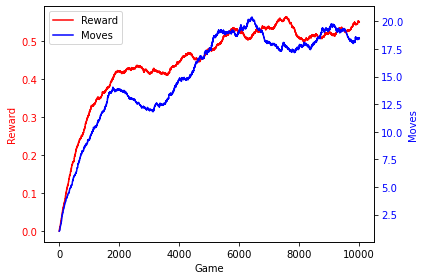

In [125]:
def exp_moving_average(data,alpha):
    alpha_rev = 1-alpha

    scale = 1/alpha_rev
    n = data.shape[0]

    r = np.arange(n)
    scale_arr = scale**r
    offset = data[0]*alpha_rev**(r+1)
    pw0 = alpha*alpha_rev**(n-1)

    mult = data*pw0*scale_arr
    cumsums = mult.cumsum()
    out = offset + cumsums*scale_arr[::-1]
    return out

fig, ax1 = plt.subplots()

ax1.set_xlabel('Game')
ax1.set_ylabel('Reward', color="red")
ax1.plot(exp_moving_average(R_save, 1/1000),color="red",label='Reward')
ax1.tick_params(axis='y', labelcolor="red")

ax2 = ax1.twinx()

ax2.set_ylabel('Moves',color="blue")
ax2.plot(exp_moving_average(N_moves_save, 1/1000),color="blue",label='Moves')
ax2.tick_params(axis='y', labelcolor="blue")

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)


fig.tight_layout()